In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [9]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [15]:
my_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=101)

In [18]:
pd.set_option('display.max_columns', None)

In [19]:
data_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

In [20]:
df = pd.read_csv(data_url)

In [21]:
df = df.rename(columns={'mode':'modes'})

In [22]:
df_main = df.groupby('track_id',as_index=False).first()

In [23]:
df_main['binary_outcome'] = np.where( df_main.track_popularity > 45, 1, 0 )

In [24]:
df_main['binary_outcome'] = df_main['binary_outcome'].astype(str)

In [25]:
df_main = df_main.drop(columns='track_popularity')

In [26]:
df_clean = df_main.select_dtypes('number').copy()

In [27]:
df_clean['danceability'] = np.log(df_main.danceability + 0.00001)
df_clean['energy'] = np.log(df_main.energy + 0.00001)
df_clean['key'] = np.log(df_main.key + 0.00001)
df_clean['modes'] = np.log(df_main.modes + 0.001)
df_clean['speechiness'] = np.log(df_main.speechiness + 0.00001)
df_clean['acousticness'] = np.log(df_main.acousticness + 0.00001)
df_clean['instrumentalness'] = np.log(df_main.instrumentalness + 0.00001)
df_clean['liveness'] = np.log(df_main.liveness + 0.00001)
df_clean['valence'] = np.log(df_main.valence + 0.00001)
df_clean['tempo'] = np.log(df_main.tempo + 0.00001)
df_clean['duration_ms'] = np.log(df_main.duration_ms + 0.00001)

In [28]:
X_clean = StandardScaler().fit_transform(df_clean)

In [29]:
df_clean['popularity'] = df_main.binary_outcome.copy()

In [30]:
df_clean['popularity'] = df_clean['popularity'].astype(int)

In [31]:
df_clean['playlist_subgenre'] = df_main.playlist_subgenre.copy()

In [4]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
import statsmodels.formula.api as smf

In [22]:
formula_1 = 'popularity ~ danceability + energy + key + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms'

formula_2 = 'popularity ~ (danceability + energy + key + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms)**2'

formula_3 = 'popularity ~ playlist_subgenre'

formula_4 = 'popularity ~ danceability + energy + key + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms + playlist_subgenre'

formula_5 = 'popularity ~ (danceability + energy + key + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms) * (playlist_subgenre)'

formula_6 = 'popularity ~ np.power(danceability, 2) + np.power(energy, 2) + np.power(key, 2) + np.power(loudness, 2) + np.power(speechiness, 2) + np.power(acousticness, 2) + np.power(instrumentalness, 2) + np.power(liveness, 2) + np.power(valence, 2) + np.power(tempo, 2) + np.power(duration_ms, 2)'

formula_7 = 'popularity ~ np.power(danceability, 4) + np.power(energy, 4) + np.power(key, 4) + np.power(loudness, 4) + np.power(speechiness, 4) + np.power(acousticness, 4) + np.power(instrumentalness, 4) + np.power(liveness, 4) + np.power(valence, 4) + np.power(tempo, 4) + np.power(duration_ms, 4)'

formula_8 = 'popularity ~ np.power(danceability, 2) + np.power(energy, 2) + np.power(key, 2) + np.power(loudness, 2) + np.power(speechiness, 2) + np.power(acousticness, 2) + np.power(instrumentalness, 2) + np.power(liveness, 2) + np.power(valence, 2) + np.power(tempo, 2) + np.power(duration_ms, 2) + (danceability + energy + key + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms) * (playlist_subgenre)'



In [23]:
fit_01 = smf.logit(formula = formula_1, data = df_clean).fit()

Optimization terminated successfully.
         Current function value: 0.666240
         Iterations 5


In [24]:
fit_06 = smf.logit(formula = formula_6, data = df_clean).fit()

Optimization terminated successfully.
         Current function value: 0.670203
         Iterations 5


In [25]:
fit_08 = smf.logit(formula = formula_8, data = df_clean).fit()

Optimization terminated successfully.
         Current function value: 0.603173
         Iterations 8


In [26]:
y_01, X_01 = dmatrices(formula_1 + ' - 1', data = df_clean)

In [27]:
from sklearn.linear_model import LogisticRegressionCV

In [28]:
ridge_tune_results = LogisticRegressionCV(penalty='l2', Cs=101, cv=my_cv, solver='lbfgs', max_iter=5001, fit_intercept=False).\
fit(X_01, y_01.ravel())

In [29]:
ridge_tune_results.C_

array([0.01])

In [30]:
ridge_tune_results.scores_.keys()

dict_keys([1.0])

In [31]:
ridge_tune_results.scores_[1.0].shape

(10, 101)

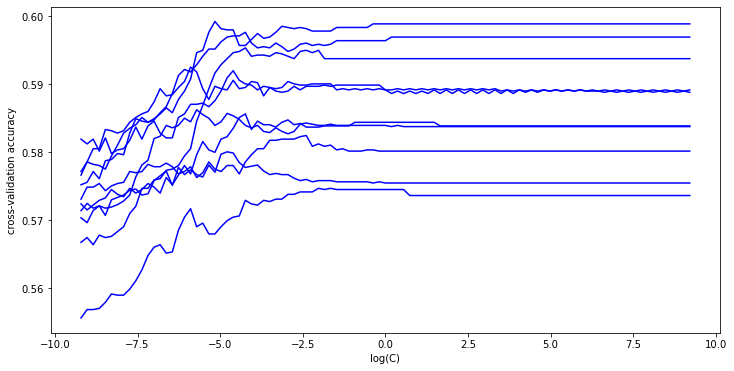

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(ridge_tune_results.Cs_), ridge_tune_results.scores_[1.0].T, 'b-')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

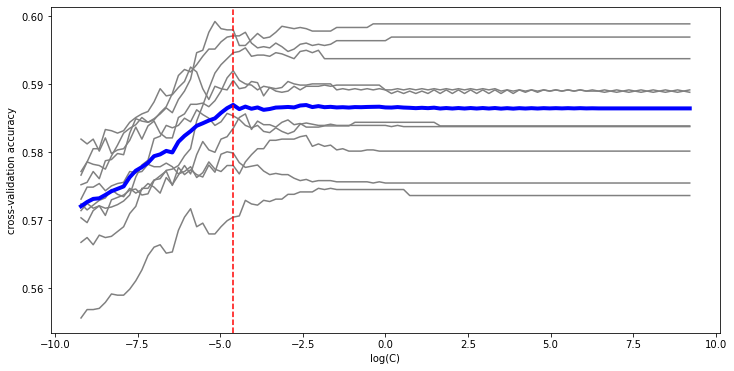

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(ridge_tune_results.Cs_), ridge_tune_results.scores_[1.0].T, color='grey')
ax.plot(np.log(ridge_tune_results.Cs_), ridge_tune_results.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(ridge_tune_results.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

In [34]:
lasso_tune_results = LogisticRegressionCV(penalty='l1', Cs=101, cv=my_cv, solver='saga', max_iter=5001, fit_intercept=False).\
fit(X_01, y_01.ravel())

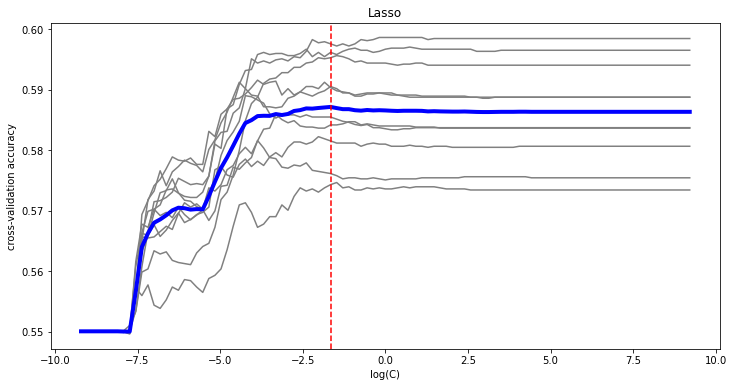

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(lasso_tune_results.Cs_), lasso_tune_results.scores_[1.0].T, color='grey')
ax.plot(np.log(lasso_tune_results.Cs_), lasso_tune_results.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(lasso_tune_results.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")
ax.set_title("Lasso")

plt.show()

In [36]:
print( ridge_tune_results.coef_)

[[ 0.03347319 -0.65776838 -0.00236918  0.06802297 -0.07441453  0.05734706
  -0.06024154 -0.05919893  0.05067887  0.30061187 -0.16366337]]


In [37]:
print( lasso_tune_results.coef_ )

[[ 0.0290111  -0.85909858 -0.00217498  0.08164722 -0.07437109  0.05032054
  -0.05877811 -0.05321839  0.0712838   0.37905067 -0.19183682]]


In [38]:
y_06, X_06 = dmatrices(formula_6 + ' - 1', data = df_clean)

In [39]:
ridge_tune_results_6 = LogisticRegressionCV(penalty='l2', Cs=101, cv=my_cv, solver='lbfgs', max_iter=5001, fit_intercept=False).\
fit(X_06, y_06.ravel())

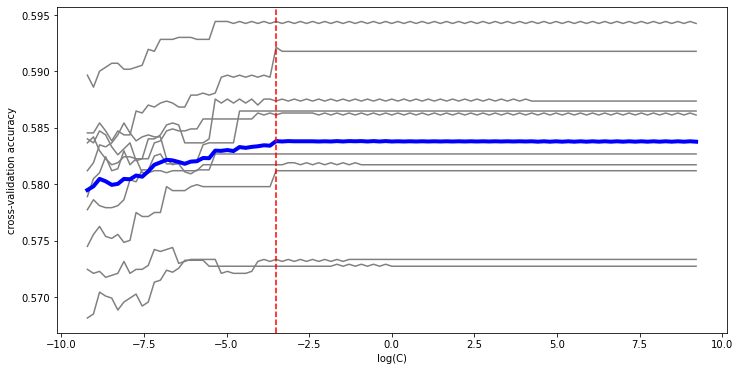

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(ridge_tune_results_6.Cs_), ridge_tune_results_6.scores_[1.0].T, color='grey')
ax.plot(np.log(ridge_tune_results_6.Cs_), ridge_tune_results_6.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(ridge_tune_results_6.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

In [41]:
lasso_tune_results_6 = LogisticRegressionCV(penalty='l1', Cs=101, cv=my_cv, solver='saga', max_iter=5001, fit_intercept=False).\
fit(X_06, y_06.ravel())

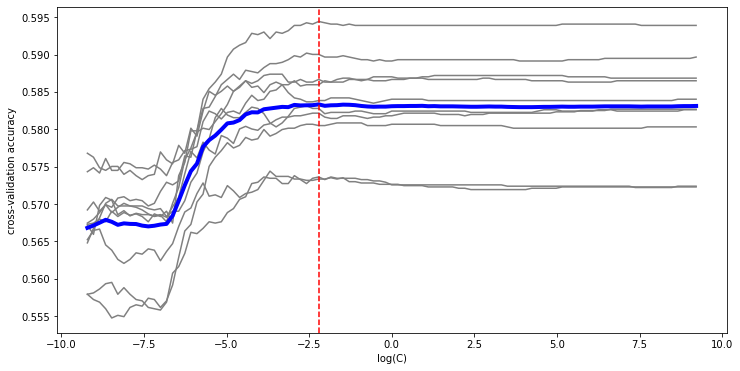

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(lasso_tune_results_6.Cs_), lasso_tune_results_6.scores_[1.0].T, color='grey')
ax.plot(np.log(lasso_tune_results_6.Cs_), lasso_tune_results_6.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(lasso_tune_results_6.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

In [43]:
print( ridge_tune_results.coef_)

[[ 0.03347319 -0.65776838 -0.00236918  0.06802297 -0.07441453  0.05734706
  -0.06024154 -0.05919893  0.05067887  0.30061187 -0.16366337]]


In [44]:
print( lasso_tune_results.coef_ )

[[ 0.0290111  -0.85909858 -0.00217498  0.08164722 -0.07437109  0.05032054
  -0.05877811 -0.05321839  0.0712838   0.37905067 -0.19183682]]


In [45]:
y_08, X_08 = dmatrices(formula_8 + ' - 1', data = df_clean)

In [46]:
ridge_tune_results_3 = LogisticRegressionCV(penalty='l2', Cs=101, cv=my_cv, solver='lbfgs', max_iter=5001, fit_intercept=False).\
fit(X_08, y_08.ravel())

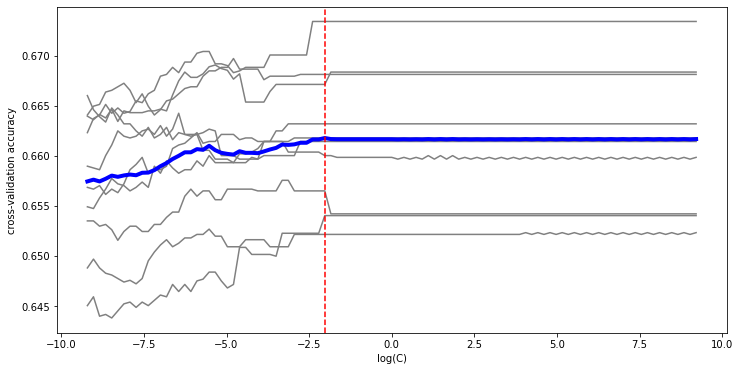

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(ridge_tune_results_3.Cs_), ridge_tune_results_3.scores_[1.0].T, color='grey')
ax.plot(np.log(ridge_tune_results_3.Cs_), ridge_tune_results_3.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(ridge_tune_results_3.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

In [48]:
lasso_tune_results_3 = LogisticRegressionCV(penalty='l1', Cs=101, cv=my_cv, solver='saga', max_iter=5001, fit_intercept=False).\
fit(X_08, y_08.ravel())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


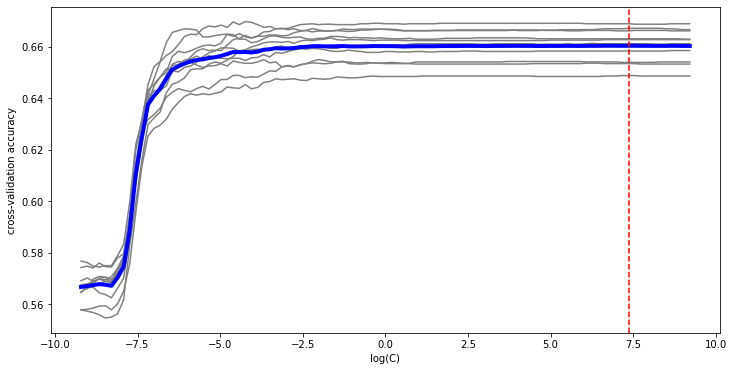

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.log(lasso_tune_results_3.Cs_), lasso_tune_results_3.scores_[1.0].T, color='grey')
ax.plot(np.log(lasso_tune_results_3.Cs_), lasso_tune_results_3.scores_[1.0].mean(axis=0), color='blue', linewidth=4)
ax.axvline(x=np.log(lasso_tune_results_3.C_), color='red', linestyle='dashed')
ax.set_xlabel('log(C)')
ax.set_ylabel("cross-validation accuracy")

plt.show()

In [50]:
print( ridge_tune_results.coef_)

[[ 0.03347319 -0.65776838 -0.00236918  0.06802297 -0.07441453  0.05734706
  -0.06024154 -0.05919893  0.05067887  0.30061187 -0.16366337]]


In [51]:
print( lasso_tune_results.coef_ )

[[ 0.0290111  -0.85909858 -0.00217498  0.08164722 -0.07437109  0.05032054
  -0.05877811 -0.05321839  0.0712838   0.37905067 -0.19183682]]


### Elastic Net

In [10]:
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

In [32]:
df_1 = df_clean.copy()

In [33]:
df_1['popularity'] = df_1['popularity'].astype(str)

In [34]:
xinputs = df_1.select_dtypes('number').copy()
youtput = df_1.loc[:, ['popularity']].copy()

In [35]:
X_train = xinputs.to_numpy()
y_train = youtput.popularity.to_numpy().ravel()

In [36]:
y_train.shape

(28356,)

In [37]:
X_train.shape

(28356, 12)

In [59]:
enet_default = LogisticRegression(penalty='elasticnet', solver='saga', random_state=101, max_iter=10001,
                                  C=1.0, l1_ratio=0.5)

In [60]:
default_enet_wflow = Pipeline( steps=[('std_inputs', StandardScaler()), 
                                      ('enet', enet_default)] )

In [61]:
my_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=101)

In [62]:
enet_default_cv = cross_val_score(default_enet_wflow, X_train, y_train, cv=my_cv)

In [63]:
enet_default_cv

array([0.58198166, 0.60835831, 0.57538353, 0.59125375, 0.5949568 ,
       0.59397038, 0.58702169, 0.5930171 , 0.58472932, 0.59478046,
       0.58797602, 0.58931405, 0.5905484 , 0.58666902, 0.59354611])

In [64]:
enet_default_cv.mean()

0.5902337750183072

In [66]:
df_1.popularity.value_counts(normalize=True)

0    0.550078
1    0.449922
Name: popularity, dtype: float64

In [2]:
from sklearn.model_selection import GridSearchCV

In [11]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga', random_state=101, max_iter=10001)

In [12]:
enet_cv_wflow = Pipeline( steps = [('std_inputs', StandardScaler()), 
                                   ('enet', enet_to_fit)] )

In [13]:
enet_grid = {'enet__C': np.exp(np.linspace(-6, 6, num=11)),
             'enet__l1_ratio': np.linspace(0, 1, num=5)}

In [16]:
enet_search = GridSearchCV(enet_cv_wflow, param_grid=enet_grid, cv=my_cv)

In [38]:
enet_search_results = enet_search.fit(X_train, y_train)

In [39]:
enet_search_results.best_score_

0.5906687271916928

In [40]:
enet_search_results.best_params_

{'enet__C': 0.09071795328941247, 'enet__l1_ratio': 0.0}